In [1]:
import os
import heapq
import numpy as np
import osmnx as ox
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
from geopy.geocoders import Nominatim
from PIL import Image

from shapely.geometry import Point

In [2]:
ox.settings.use_cache = True
ox.settings.log_console = True

In [3]:
# Definir la consulta Overpass
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["name"="Ciudad de México"]->.searchArea;
(
  nwr["admin_level"="6"]["name"="Cuauhtémoc"](area.searchArea);
);
/*added by auto repair*/
(._;>;);
/*end of auto repair*/
out body;
"""

response = requests.get(overpass_url, params={"data": overpass_query})
response_data = response.json()

elements = response_data["elements"]
nodes = [el for el in elements if el["type"] == "node"]
ways = [el for el in elements if el["type"] == "way"]
relations = [el for el in elements if el["type"] == "relation"]

nodes = gpd.GeoDataFrame(nodes)
nodes["geometry"] = nodes.apply(lambda x: Point(x["lon"], x["lat"]), axis=1)

nodes_polygon = nodes.unary_union.convex_hull

graph = ox.graph_from_polygon(nodes_polygon, network_type="drive")

/var/folders/51/qg1r196n7wgdfhckhzgbxbz40000gn/T/ipykernel_51517/3789282954.py:24: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  nodes["geometry"] = nodes.apply(lambda x: Point(x["lon"], x["lat"]), axis=1)


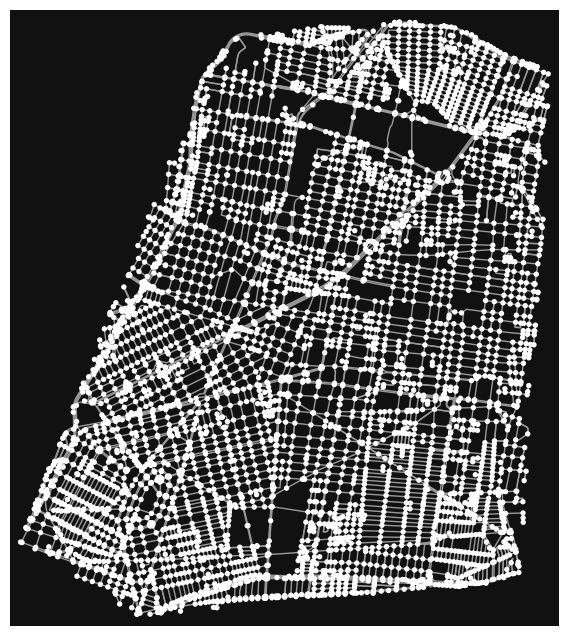

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
ox.plot_graph(graph)

In [5]:
MAX_SPEED_IN_SECONDARY_ROAD_IN_KM_H = 30

for edge in graph.edges:
    maxspeed = MAX_SPEED_IN_SECONDARY_ROAD_IN_KM_H

    if "maxspeed" in graph.edges[edge]:
        maxspeed = graph.edges[edge]["maxspeed"]
        match maxspeed:
            case str():
                maxspeed = int(maxspeed)
            case list():
                maxspeed = min([int(speed) for speed in maxspeed])

    graph.edges[edge]["maxspeed"] = maxspeed
    graph.edges[edge]["weight"] = graph.edges[edge]["length"] / maxspeed

In [6]:
def style_edge(place_graph, edge, color, alpha, linewidth):
    place_graph.edges[edge]["color"] = color
    place_graph.edges[edge]["alpha"] = alpha
    place_graph.edges[edge]["linewidth"] = linewidth


def style_unvisited_edge(place_graph, edge):
    style_edge(place_graph, edge, "#D36206", 0.2, 0.5)


def style_visited_edge(place_graph, edge):
    style_edge(place_graph, edge, "#D36206", 1, 1)


def style_active_edge(place_graph, edge):
    style_edge(place_graph, edge, "#E8A900", 1, 1)


def style_path_edge(place_graph, edge):
    style_edge(place_graph, edge, "WHITE", 1, 1)

In [7]:
def plot_graph(place_graph, axis):
    return ox.plot_graph(
        place_graph,
        node_size=[place_graph.nodes[node]["size"] for node in place_graph.nodes],
        edge_color=[place_graph.edges[edge]["color"] for edge in place_graph.edges],
        edge_alpha=[place_graph.edges[edge]["alpha"] for edge in place_graph.edges],
        edge_linewidth=[
            place_graph.edges[edge]["linewidth"] for edge in place_graph.edges
        ],
        node_color="white",
        bgcolor="#18080E",
        ax=axis,
        show=False,
        save=False,
        close=False,
    )

In [8]:
def save_plot_graph(place_graph, path, iteration):
    filepath = f"frames/{path}/frame_{iteration:04d}.png"
    ox.plot_graph(
        place_graph,
        node_size=[place_graph.nodes[node]["size"] for node in place_graph.nodes],
        edge_color=[place_graph.edges[edge]["color"] for edge in place_graph.edges],
        edge_alpha=[place_graph.edges[edge]["alpha"] for edge in place_graph.edges],
        edge_linewidth=[
            place_graph.edges[edge]["linewidth"] for edge in place_graph.edges
        ],
        node_color="white",
        bgcolor="#18080E",
        save=True,
        filepath=filepath,
        show=False,
        close=True,
    )

In [9]:
def dijkstra(
    place_graph,
    origin,
    destination,
    plot=False,
):
    for node in place_graph.nodes:
        place_graph.nodes[node]["visited"] = False
        place_graph.nodes[node]["distance"] = float("inf")
        place_graph.nodes[node]["previous"] = None
        place_graph.nodes[node]["size"] = 0

    for edge in place_graph.edges:
        style_unvisited_edge(place_graph, edge)

    place_graph.nodes[origin]["distance"] = 0
    place_graph.nodes[origin]["size"] = 25
    place_graph.nodes[destination]["size"] = 25

    queue = [(0, origin)]

    iterations = 0

    if plot:
        save_plot_graph(place_graph, dijkstra.__name__, iterations)

    while queue:
        _, node = heapq.heappop(queue)
        if node == destination:
            if plot:
                save_plot_graph(place_graph, dijkstra.__name__, iterations)
            return

        if place_graph.nodes[node]["visited"]:
            continue

        place_graph.nodes[node]["visited"] = True

        for edge in place_graph.out_edges(node):
            style_visited_edge(place_graph, (edge[0], edge[1], 0))

            neighbor = edge[1]
            weight = place_graph.edges[(edge[0], edge[1], 0)]["weight"]

            if (
                place_graph.nodes[neighbor]["distance"]
                > place_graph.nodes[node]["distance"] + weight
            ):
                place_graph.nodes[neighbor]["distance"] = (
                    place_graph.nodes[node]["distance"] + weight
                )
                place_graph.nodes[neighbor]["previous"] = node

                heapq.heappush(
                    queue, (place_graph.nodes[neighbor]["distance"], neighbor)
                )

                for neighbor_edge in place_graph.out_edges(neighbor):
                    style_active_edge(
                        place_graph, (neighbor_edge[0], neighbor_edge[1], 0)
                    )

        iterations += 1
        if plot and iterations % 10 == 0:
            save_plot_graph(place_graph, dijkstra.__name__, iterations)

In [10]:
def distance(place_graph, node1, node2):
    x1, y1 = place_graph.nodes[node1]["x"], place_graph.nodes[node1]["y"]
    x2, y2 = place_graph.nodes[node2]["x"], place_graph.nodes[node2]["y"]
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5


def a_star(
    place_graph,
    origin,
    destination,
    plot=False,
):
    for node in place_graph.nodes:
        place_graph.nodes[node]["previous"] = None
        place_graph.nodes[node]["size"] = 0
        place_graph.nodes[node]["g_score"] = float("inf")
        place_graph.nodes[node]["f_score"] = float("inf")

    for edge in place_graph.edges:
        style_unvisited_edge(place_graph, edge)

    place_graph.nodes[origin]["size"] = 50
    place_graph.nodes[destination]["size"] = 50
    place_graph.nodes[origin]["g_score"] = 0
    place_graph.nodes[origin]["f_score"] = distance(place_graph, origin, destination)

    queue = [(place_graph.nodes[origin]["f_score"], origin)]

    iterations = 0

    if plot:
        save_plot_graph(place_graph, a_star.__name__, iterations)

    while queue:
        _, node = heapq.heappop(queue)

        if node == destination:
            if plot:
                save_plot_graph(place_graph, a_star.__name__, iterations)
            break

        for edge in place_graph.out_edges(node):
            style_visited_edge(place_graph, (edge[0], edge[1], 0))

            neighbor = edge[1]
            tentative_g_score = place_graph.nodes[node]["g_score"] + distance(
                place_graph, node, neighbor
            )

            if tentative_g_score < place_graph.nodes[neighbor]["g_score"]:
                place_graph.nodes[neighbor]["previous"] = node
                place_graph.nodes[neighbor]["g_score"] = tentative_g_score
                place_graph.nodes[neighbor]["f_score"] = tentative_g_score + distance(
                    place_graph, neighbor, destination
                )

                heapq.heappush(
                    queue, (place_graph.nodes[neighbor]["f_score"], neighbor)
                )

                for neighbor_edge in place_graph.out_edges(neighbor):
                    style_active_edge(
                        place_graph, (neighbor_edge[0], neighbor_edge[1], 0)
                    )

            iterations += 1

            if plot and iterations % 10 == 0:
                save_plot_graph(place_graph, a_star.__name__, iterations)

In [11]:
class Node:
    def __init__(self, graph, id, previous=None):
        self.node = graph.nodes[id]
        self.previous = previous
        self.id = id
        self.graph = graph

    def expand(self):
        children = [
            Node(self.graph, edge[1], self) for edge in self.graph.out_edges(self.id)
        ]
        return children

    def path(self):
        node = self
        path = []
        while node:
            path.append(node.id)
            node = node.previous
        return path[::-1]

    def cost(self):
        node = self
        cost = 0
        while node.previous:
            cost += self.graph.edges[(node.previous.id, node.id, 0)]["weight"]
            node = node.previous
        return cost

    def __eq__(self, other):
        try:
            return self.id == other.id
        except:
            return self.id == other

    def __hash__(self):
        return hash(self.id)

In [56]:
ALPHA = 1.0
BETA = 5.0
RHO = 0.25
Q = 1

NUMBER_OF_ANTS = 10
MAXIMUM_NUMBER_OF_GENERATIONS = 100

In [13]:
def ant_colony(place_graph: nx.MultiDiGraph, origin: int, destination: int, plot=False):
    origin = Node(place_graph, origin)
    destination = Node(place_graph, destination)

    for node in place_graph.nodes:
        place_graph.nodes[node]["previous"] = None
        place_graph.nodes[node]["size"] = 0

    for edge in place_graph.edges:
        style_unvisited_edge(place_graph, edge)

    place_graph.nodes[origin.id]["size"] = 50
    place_graph.nodes[destination.id]["size"] = 50

    pheromones = dict()
    pheromones = {edge: np.random.uniform(0, 0.5) for edge in place_graph.edges}

    best_path = []
    best_path_cost = float("inf")

    paths = []
    paths_costs = []

    for generation in range(MAXIMUM_NUMBER_OF_GENERATIONS):
        for ant in range(NUMBER_OF_ANTS):
            nodes_queue: list[Node] = [origin]
            nodes_visited = []

            path = []
            path_cost = 0
            path_found = False

            while nodes_queue and not path_found:
                current_node = nodes_queue.pop(0)

                nodes_visited.append(current_node)

                nodes: list[int] = []
                nodes_probabilities: list[float] = []

                for child in current_node.expand():
                    if child == destination:
                        path_found = True
                        path = child.path()
                        path_cost = child.cost()
     
                        if plot: 
                            if (((generation * NUMBER_OF_ANTS) + ant) % 10) == 0:
                                reconstruct_path_from_list(graph, path, origin.id, destination.id)
                                save_plot_graph(place_graph, ant_colony.__name__, ((generation * NUMBER_OF_ANTS) + ant))

                        break

                    if child not in nodes_visited:
                        nodes.append(child)
                        nodes_probabilities.append(
                            pheromones[(child.previous.id, child.id, 0)] ** ALPHA
                            * (
                                1
                                / place_graph.edges[(child.previous.id, child.id, 0)][
                                    "weight"
                                ]
                            )
                            ** BETA
                        )

                if path_found:
                    continue

                if not nodes:
                    continue

                nodes_probabilities_cumulative: float = np.sum(nodes_probabilities)
                nodes_probabilities_weighted: list[float] = [
                    probability / nodes_probabilities_cumulative
                    for probability in nodes_probabilities
                ]

                next_node = np.random.choice(
                    nodes,
                    p=nodes_probabilities_weighted,
                )

                nodes.remove(next_node)
                nodes_queue.extend(nodes)
                nodes_queue.insert(0, next_node)

            if path_cost < best_path_cost:
                best_path = path
                best_path_cost = path_cost

            paths.append(path)
            paths_costs.append(path_cost)

            pheromones = {edge: (1 - RHO) * pheromones[edge] for edge in pheromones}
            for path, cost in zip(paths, paths_costs):
                for i in range(len(path) - 1):
                    pheromones[(path[i], path[i + 1], 0)] += Q / cost

    return best_path, best_path_cost

In [14]:
def reconstruct_path(
    place_graph,
    origin,
    destination,
):
    for edge in place_graph.edges:
        style_unvisited_edge(place_graph, edge)

    distance = 0
    speeds = []

    current_node = destination

    while current_node != origin:
        previous_node = place_graph.nodes[current_node]["previous"]

        distance += place_graph.edges[(previous_node, current_node, 0)]["length"]
        speeds.append(place_graph.edges[(previous_node, current_node, 0)]["maxspeed"])

        style_path_edge(place_graph, (previous_node, current_node, 0))

        current_node = previous_node

    distance /= 1000

    print(f"Distance: {distance}")
    print(f"Avg. speed: {sum(speeds)/len(speeds)}")
    print(f"Total time: {distance/(sum(speeds)/len(speeds)) * 60}")

In [15]:
def reconstruct_path_from_list(
    place_graph,
    nodes: list[int],
    origin,
    destination,
):
    for edge in place_graph.edges:
        style_unvisited_edge(place_graph, edge)

    distance = 0
    speeds = []

    path = nodes.copy()
    current_node = path.pop()

    while current_node != origin:
        previous_node = path.pop()

        distance += place_graph.edges[(previous_node, current_node, 0)]["length"]
        speeds.append(place_graph.edges[(previous_node, current_node, 0)]["maxspeed"])

        style_path_edge(place_graph, (previous_node, current_node, 0))

        current_node = previous_node

    distance /= 1000

    print(f"Distance: {distance}")
    print(f"Avg. speed: {sum(speeds)/len(speeds)}")
    print(f"Total time: {distance/(sum(speeds)/len(speeds)) * 60}")

In [16]:
geolocator = Nominatim(user_agent="pathfinding-comparison")


address1 = "Calle Sabino, Santa María la Ribera, Mexico City, Cuauhtémoc, Mexico City, 06400, Mexico"
address2 = "Palacio de Bellas Artes, Avenida Juárez, Barrio Chino, Centro, Mexico City, Cuauhtémoc, Mexico City, 06050, Mexico"


location1 = geolocator.geocode(address1)
location2 = geolocator.geocode(address2)


point1 = (location1.latitude, location1.longitude)
point2 = (location2.latitude, location2.longitude)


node1 = ox.distance.nearest_nodes(graph, point1[1], point1[0])
node2 = ox.distance.nearest_nodes(graph, point2[1], point2[0])

In [22]:
%%time
a_star(graph, node1, node2, plot=True)

CPU times: user 18.6 ms, sys: 1.12 ms, total: 19.7 ms
Wall time: 19 ms


In [ ]:
reconstruct_path(graph, node1, node2)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

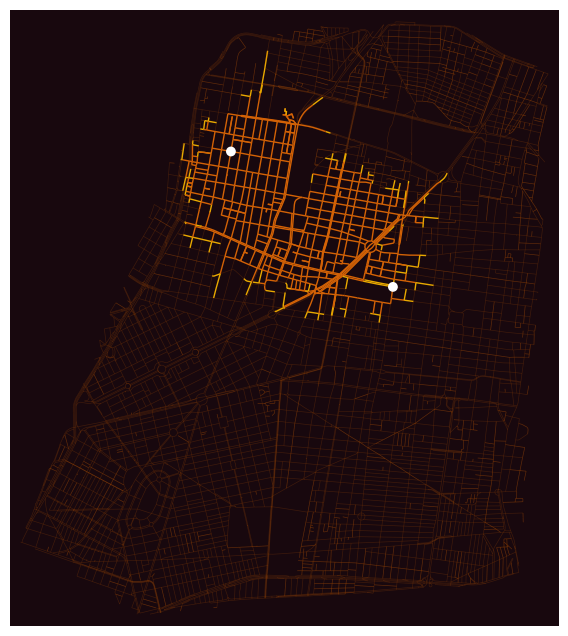

In [18]:
plot_graph(graph, None)

In [ ]:
save_plot_graph(graph, a_star.__name__, 936)

In [ ]:
IMAGES_DIRECTORY = "frames/a_star"

images = [
    os.path.join(IMAGES_DIRECTORY, f)
    for f in os.listdir(IMAGES_DIRECTORY)
    if f.endswith(".png")
]
images.sort()

fig, ax = plt.subplots()
fig.patch.set_facecolor("#18080E")
ax.axis("off")

image = ax.imshow(Image.open(images[0]))


def update_img(n):
    image.set_array(Image.open(images[n]))
    return (image,)


ani = animation.FuncAnimation(
    fig, update_img, frames=len(images), interval=100, blit=True
)
ani.save("a_star.mp4", writer="ffmpeg")


plt.show()

In [23]:
%%time
dijkstra(graph, node1, node2, plot=True)

CPU times: user 25.3 ms, sys: 934 μs, total: 26.2 ms
Wall time: 25.6 ms


In [ ]:
reconstruct_path(graph, node1, node2)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

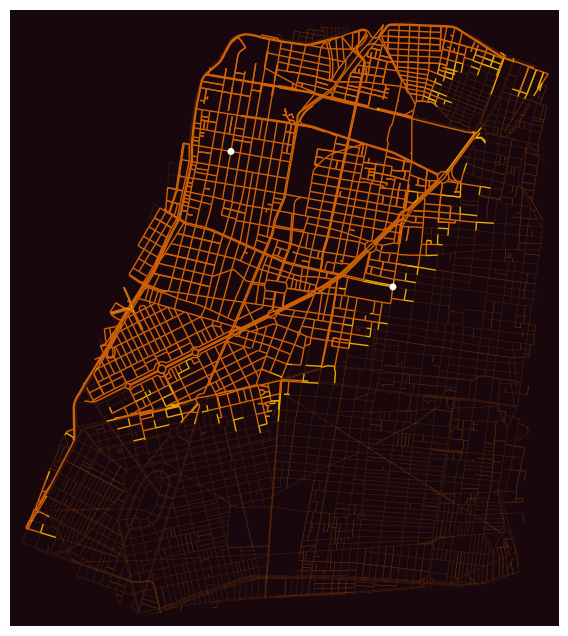

In [20]:
plot_graph(graph, None)

In [ ]:
save_plot_graph(graph, dijkstra.__name__, 1826)

In [ ]:
IMAGES_DIRECTORY = "frames/dijkstra"

images = [
    os.path.join(IMAGES_DIRECTORY, f)
    for f in os.listdir(IMAGES_DIRECTORY)
    if f.endswith(".png")
]
images.sort()

fig, ax = plt.subplots()
fig.patch.set_facecolor("#18080E")
ax.axis("off")

image = ax.imshow(Image.open(images[0]))


def update_img(n):
    image.set_array(Image.open(images[n]))
    return (image,)


ani = animation.FuncAnimation(
    fig, update_img, frames=len(images), interval=100, blit=True
)
ani.save("dijkstra.mp4", writer="ffmpeg")


plt.show()

Distance: 4.253026
Avg. speed: 33.111111111111114
Total time: 7.706825637583892
Distance: 4.334289
Avg. speed: 32.666666666666664
Total time: 7.9609389795918375
Distance: 6.277959000000003
Avg. speed: 31.142857142857142
Total time: 12.095150366972481
Distance: 6.613760000000003
Avg. speed: 31.05263157894737
Total time: 12.77912949152543
Distance: 8.670468000000001
Avg. speed: 31.18811881188119
Total time: 16.680328914285717
Distance: 8.670468000000001
Avg. speed: 31.18811881188119
Total time: 16.680328914285717
Distance: 8.670468000000001
Avg. speed: 31.18811881188119
Total time: 16.680328914285717
Distance: 8.670468000000001
Avg. speed: 31.18811881188119
Total time: 16.680328914285717
Distance: 8.670468000000001
Avg. speed: 31.18811881188119
Total time: 16.680328914285717
Distance: 8.670468000000001
Avg. speed: 31.18811881188119
Total time: 16.680328914285717
Distance: 8.670468000000001
Avg. speed: 31.18811881188119
Total time: 16.680328914285717
Distance: 8.670468000000001
Avg. speed

KeyboardInterrupt: 

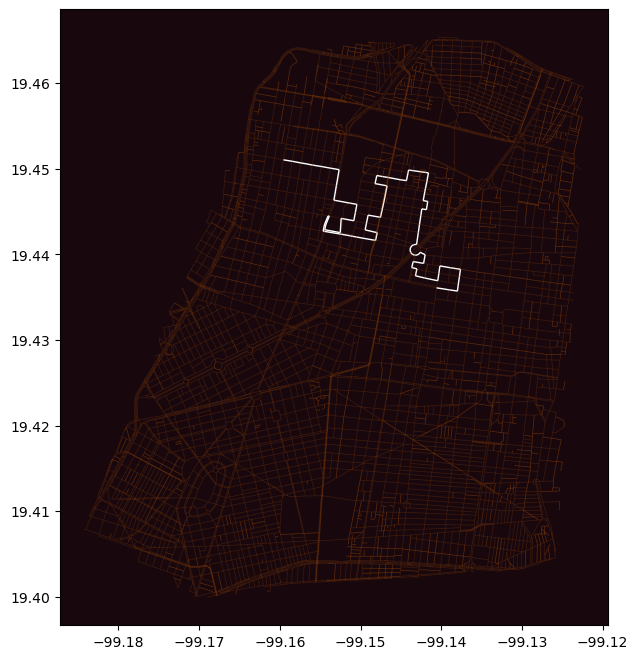

In [57]:
%%time
(path, cost) = ant_colony(graph, node1, node2, plot=True)

In [ ]:
reconstruct_path_from_list(graph, path, node1, node2)

Distance: 4.527977000000001
Avg. speed: 31.568627450980394
Total time: 8.605968708074535


(<Figure size 800x800 with 1 Axes>, <Axes: >)

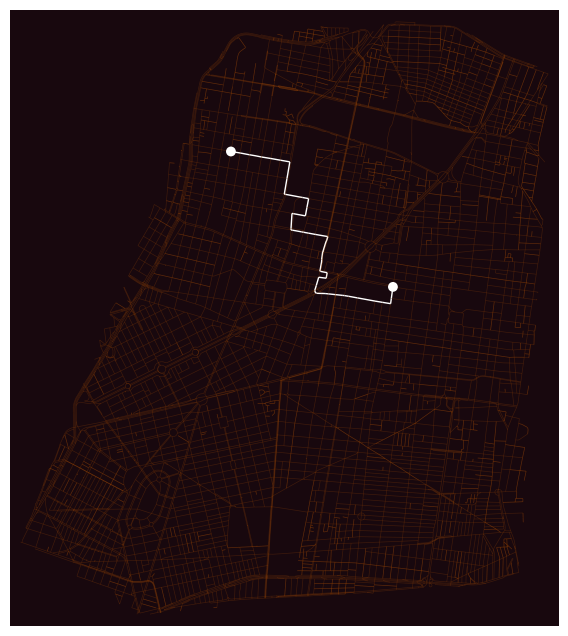

In [ ]:
plot_graph(graph, None)

In [ ]:
save_plot_graph(graph, ant_colony.__name__, 1000)

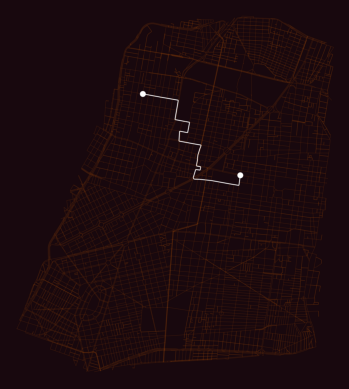

In [ ]:
IMAGES_DIRECTORY = "frames/ant_colony"

images = [
    os.path.join(IMAGES_DIRECTORY, f)
    for f in os.listdir(IMAGES_DIRECTORY)
    if f.endswith(".png")
]
images.sort()

fig, ax = plt.subplots()
fig.patch.set_facecolor("#18080E")
ax.axis("off")

image = ax.imshow(Image.open(images[0]))


def update_img(n):
    image.set_array(Image.open(images[n]))
    return (image,)


ani = animation.FuncAnimation(
    fig, update_img, frames=len(images), interval=100, blit=True
)
ani.save("ant_colony.mp4", writer="ffmpeg")


plt.show()